In [ ]:
!pip install kornia

In [ ]:
!git clone https://github.com/kornia/kornia-examples

In [ ]:
!mv kornia-examples/* .

In [ ]:
# Right Image
!wget https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Playtable-perfect/im1.png
!wget https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Playtable-perfect/disp1.pfm

In [ ]:
# Left Image
!wget https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Playtable-perfect/im0.png
!wget https://vision.middlebury.edu/stereo/data/scenes2014/datasets/Playtable-perfect/disp0.pfm

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [44]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Using ', device)

Using  cpu


In [81]:
def load_data(filename):
    data = torch.from_numpy(data_np)
    return data

def data_to_vis(data):
    return kornia.tensor_to_image(data) / 255.

def data_to_vis_without_normalize(data):
    return kornia.tensor_to_image(data)


In [46]:
!ls

disp0.pfm  disp1.pfm  im0.png  im1.png	sample_data


In [47]:
right_depth: np.array = cv2.imread('/content/disp1.pfm', cv2.IMREAD_UNCHANGED)
left_depth: np.array = cv2.imread('/content/disp0.pfm', cv2.IMREAD_UNCHANGED)

right_depth[right_depth==np.inf] = 0
right_depth: np.array = cv2.normalize(right_depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

left_depth[left_depth==np.inf] = 0
left_depth: np.array = cv2.normalize(left_depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

right: np.array = cv2.imread('/content/im1.png')
left: np.array = cv2.imread('/content/im0.png')

right: np.array = cv2.normalize(right, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
left: np.array = cv2.normalize(left, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


In [48]:
right_camera_matrix = np.array([
    [2329.558, 0, 1241.731],
    [0, 2329.558, 927.052],
    [0, 0, 1]
])

left_camera_matrix = np.array([
    [2329.558, 0, 1141.452],
    [0, 2329.558, 927.052],
    [0, 0, 1]
])

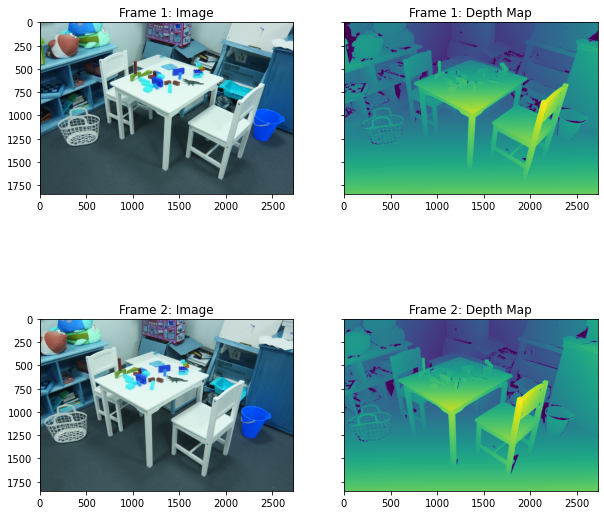

In [49]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)

axes[0, 0].imshow((left))
axes[0, 0].set_title('Frame 1: Image')

axes[0, 1].imshow((left_depth))
axes[0, 1].set_title('Frame 1: Depth Map')

axes[1, 0].imshow((right))
axes[1, 0].set_title('Frame 2: Image')

axes[1, 1].imshow((right_depth))
axes[1, 1].set_title('Frame 2: Depth Map')

plt.show()

### Predict using good estimated depth

In [50]:
left: torch.tensor = kornia.image_to_tensor(left)  # CxHxW / torch.uint8
right: torch.tensor = kornia.image_to_tensor(right)  # CxHxW / torch.uint8
left_depth: torch.tensor = kornia.image_to_tensor(left_depth)  # CxHxW / torch.uint8
right_depth: torch.tensor = kornia.image_to_tensor(right_depth)  # CxHxW / torch.uint8

In [51]:
transform = torchvision.transforms.ToTensor()

In [52]:
left_camera_matrix: torch.tensor = transform(left_camera_matrix)
right_camera_matrix: torch.tensor = transform(right_camera_matrix)

In [53]:
left = left.to(device)
right = right.to(device)
left_depth = left_depth.to(device)
right_depth = right_depth.to(device)


In [54]:
left_camera_matrix = left_camera_matrix.to(device)
right_camera_matrix = right_camera_matrix.to(device)

In [95]:
# Camera transformation matrix between 
transform_from_left_to_right = torch.tensor(
    (
        (1, 0, 0, 8),
        (0, 1, 0, 0),
        (0, 0, 1, 0),
        (0, 0, 0, 1),
    )
)[None].to(device)
transform_from_left_to_right = transform_from_left_to_right.float()

In [56]:
left = left.float()
right = right.float()
left_depth = left_depth.float()
right_depth = right_depth.float()
left_camera_matrix = left_camera_matrix.float()
right_camera_matrix = right_camera_matrix.float()

In [57]:
left = left.expand(1, -1, -1, -1)
right = right.expand(1, -1, -1, -1)
left_depth = left_depth.expand(1, -1, -1, -1)
right_depth = right_depth.expand(1, -1, -1, -1)


In [96]:
generated_right = kornia.geometry.warp_frame_depth(
    image_src=left,
    depth_dst=right_depth,
    src_trans_dst=transform_from_left_to_right,
    camera_matrix=left_camera_matrix,
    normalize_points=True
)

generated_left = kornia.geometry.warp_frame_depth(
    image_src=right,
    depth_dst=left_depth,
    src_trans_dst=torch.inverse(transform_from_left_to_right),
    camera_matrix=right_camera_matrix,
    normalize_points=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


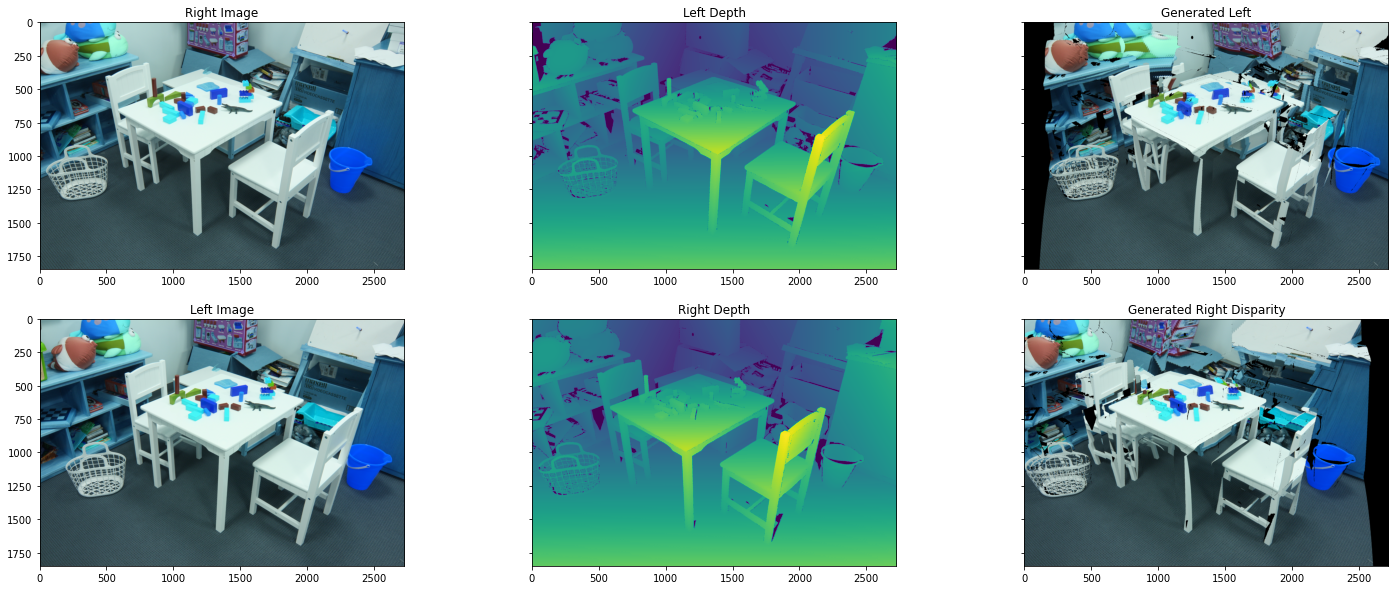

In [97]:
%matplotlib inline
fig, axes = plt.subplots(2, 3, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(25)

axes[0, 0].imshow(data_to_vis(right))
axes[0, 0].set_title('Right Image')
axes[0, 1].imshow(data_to_vis(left_depth))
axes[0, 1].set_title('Left Depth')
axes[0, 2].imshow(data_to_vis(generated_left))
axes[0, 2].set_title('Generated Left')

axes[1, 0].imshow(data_to_vis(left))
axes[1, 0].set_title('Left Image')
axes[1, 1].imshow(data_to_vis(right_depth))
axes[1, 1].set_title('Right Depth')
axes[1, 2].imshow(data_to_vis(generated_right))
axes[1, 2].set_title('Generated Right Disparity')

plt.show()


In [73]:
loss = torch.nn.L1Loss()
output = loss(right, generated_right)
output

tensor(40.3839)

In [74]:
output = loss(left, generated_left)
output

tensor(40.4354)

### Predict with an incorrect depth

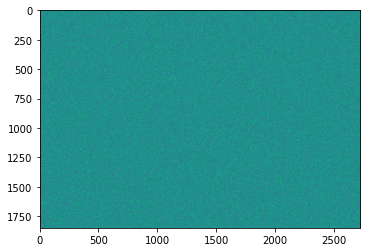

In [88]:
bad_depth = torch.rand(left_depth.shape)
plt.imshow(data_to_vis(bad_depth))
plt.show()

In [89]:
generated_right = kornia.geometry.warp_frame_depth(
    image_src=left,
    depth_dst=bad_depth,
    src_trans_dst=transform_from_left_to_right,
    camera_matrix=left_camera_matrix,
)

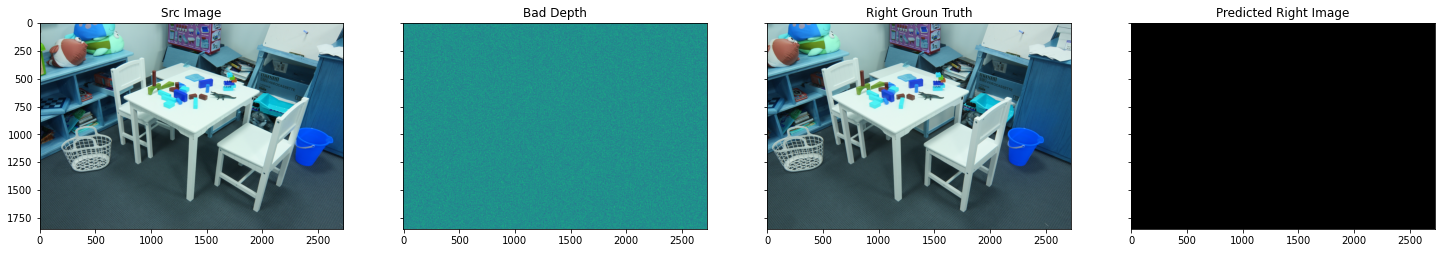

In [90]:
%matplotlib inline
fig, axes = plt.subplots(1, 4, sharey=True)
fig.set_figheight(25)
fig.set_figwidth(25)

axes[0].imshow(data_to_vis(left))
axes[0].set_title('Src Image')

axes[1].imshow(data_to_vis(bad_depth))
axes[1].set_title('Bad Depth')

axes[2].imshow(data_to_vis(right))
axes[2].set_title('Right Groun Truth')

axes[3].imshow(data_to_vis_without_normalize(generated_right))
axes[3].set_title('Predicted Right Image')
plt.show()

In [91]:
loss = torch.nn.L1Loss()
output = loss(right, generated_right)
output

tensor(114.6447)